In [11]:

# avant de lancer ce notebook, assurez-vous que les notebooks collect_articles.ipynb et enrich_articles.ipynb ont été exécutés pour collecter et enrichir les articles.

%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Configuration
base_dir = Path().resolve().parent.parent
sys.path.append(str(base_dir / "src"))

from config.database import engine, SessionLocal
from data.models import Base
from data.database_manager import DatabaseManager

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
sns.set_palette("husl")


In [13]:
# Recherche des fichiers d'articles enrichis
exports_dir = base_dir / "data" / "exports"
enriched_files = []

# Rechercher tous les fichiers enrichis
patterns = ["enriched_articles_*.json", "enriched_light_*.json", "enriched_articles.json"]

for pattern in patterns:
    files = list(exports_dir.glob(pattern))
    for file_path in files:
        file_time = datetime.fromtimestamp(file_path.stat().st_mtime)
        file_age_hours = (datetime.now() - file_time).total_seconds() / 3600
        file_size_kb = file_path.stat().st_size / 1024
        
        enriched_files.append({
            'path': file_path,
            'name': file_path.name,
            'time': file_time,
            'age_hours': file_age_hours,
            'size_kb': file_size_kb,
            'has_embeddings': 'light' not in file_path.name.lower()
        })

# Affichage des fichiers trouvés
if enriched_files:
    print("FICHIERS ENRICHIS TROUVÉS:")
    for i, file_info in enumerate(enriched_files, 1):
        print(f"   {i}. {file_info['name']}")
        print(f"      {file_info['time'].strftime('%Y-%m-%d %H:%M')} | {file_info['age_hours']:.1f}h | {file_info['size_kb']:.1f}KB")
        print(f"      Embeddings: {'Oui' if file_info['has_embeddings'] else 'Non'}")
    
    # Sélection du fichier le plus récent avec embeddings si possible
    files_with_embeddings = [f for f in enriched_files if f['has_embeddings']]
    if files_with_embeddings:
        latest_enriched = max(files_with_embeddings, key=lambda x: x['time'])
    else:
        latest_enriched = max(enriched_files, key=lambda x: x['time'])
    
    print(f"\nFICHIER SÉLECTIONNÉ: {latest_enriched['name']}")
    
else:
    print("AUCUN FICHIER ENRICHI TROUVÉ")
    print("Tentative de récupération depuis la base de données...")
    
    # Fallback vers BDD
    Base.metadata.create_all(bind=engine)
    session = SessionLocal()
    db = DatabaseManager(session=session)
    
    # Récupération des articles enrichis depuis la BDD
    enriched_data = db.get_latest_articles_enriched(limit=1000)
    
    if not enriched_data:
        print("AUCUN ARTICLE ENRICHI TROUVÉ EN BASE")
        print("Solutions:")
        print("   1. Exécutez d'abord le notebook d'enrichissement")
        print("   2. Vérifiez que l'enrichissement a bien fonctionné")
        exit(1)
    
    print(f"Articles enrichis récupérés de la BDD: {len(enriched_data)}")
    latest_enriched = None

FICHIERS ENRICHIS TROUVÉS:
   1. enriched_articles.json
      2025-07-26 09:34 | 0.1h | 5822.3KB
      Embeddings: Oui

FICHIER SÉLECTIONNÉ: enriched_articles.json


In [14]:

# Chargement des données
if latest_enriched:
    # Chargement depuis fichier JSON
    with open(latest_enriched['path'], 'r', encoding='utf-8') as f:
        enriched_articles = json.load(f)
    data_source = "JSON"
    print(f"Articles chargés depuis JSON: {len(enriched_articles)}")
else:
    # Utilisation des données BDD
    enriched_articles = enriched_data
    data_source = "BDD"
    print(f"Articles chargés depuis BDD: {len(enriched_articles)}")




Articles chargés depuis JSON: 200


In [15]:
# Conversion en DataFrame
df = pd.DataFrame(enriched_articles)
print(f"DataFrame créé: {len(df)} lignes, {len(df.columns)} colonnes")


DataFrame créé: 200 lignes, 13 colonnes


In [16]:
# Statistiques générales
print("STATISTIQUES GÉNÉRALES:")
print(f"   Total articles: {len(df)}")
print(f"   Source des données: {data_source}")

# Analyse des colonnes d'enrichissement
enrichment_columns = ['quality_score', 'language', 'entities', 'embedding', 'sentiment_score']
available_columns = [col for col in enrichment_columns if col in df.columns]

print(f"\nCOLONNES D'ENRICHISSEMENT DISPONIBLES:")
for col in available_columns:
    non_null_count = df[col].notna().sum()
    percentage = (non_null_count / len(df)) * 100
    print(f"   {col}: {non_null_count}/{len(df)} ({percentage:.1f}%)")

# Analyse des scores de qualité
if 'quality_score' in df.columns:
    quality_scores = df['quality_score'].dropna()
    if len(quality_scores) > 0:
        print(f"\nSCORES DE QUALITÉ:")
        print(f"   Moyenne: {quality_scores.mean():.3f}")
        print(f"   Médiane: {quality_scores.median():.3f}")
        print(f"   Écart-type: {quality_scores.std():.3f}")
        print(f"   Min: {quality_scores.min():.3f}")
        print(f"   Max: {quality_scores.max():.3f}")
        
        # Distribution des scores
        print(f"\nDISTRIBUTION PAR QUALITÉ:")
        high_quality = (quality_scores >= 0.8).sum()
        medium_quality = ((quality_scores >= 0.5) & (quality_scores < 0.8)).sum()
        low_quality = (quality_scores < 0.5).sum()
        
        print(f"   Haute qualité (≥0.8): {high_quality} ({high_quality/len(quality_scores)*100:.1f}%)")
        print(f"   Qualité moyenne (0.5-0.8): {medium_quality} ({medium_quality/len(quality_scores)*100:.1f}%)")
        print(f"   Qualité faible (<0.5): {low_quality} ({low_quality/len(quality_scores)*100:.1f}%)")

# Analyse des langues
if 'language' in df.columns:
    languages = df['language'].value_counts()
    print(f"\nLANGUES DÉTECTÉES:")
    for lang, count in languages.head(10).items():
        percentage = (count / len(df)) * 100
        print(f"   {lang}: {count} articles ({percentage:.1f}%)")




STATISTIQUES GÉNÉRALES:
   Total articles: 200
   Source des données: JSON

COLONNES D'ENRICHISSEMENT DISPONIBLES:
   quality_score: 200/200 (100.0%)
   language: 200/200 (100.0%)
   entities: 200/200 (100.0%)
   embedding: 200/200 (100.0%)

SCORES DE QUALITÉ:
   Moyenne: 0.212
   Médiane: 0.220
   Écart-type: 0.030
   Min: 0.110
   Max: 0.273

DISTRIBUTION PAR QUALITÉ:
   Haute qualité (≥0.8): 0 (0.0%)
   Qualité moyenne (0.5-0.8): 0 (0.0%)
   Qualité faible (<0.5): 200 (100.0%)

LANGUES DÉTECTÉES:
   fr: 130 articles (65.0%)
   en: 70 articles (35.0%)


In [17]:
# ANALYSE D'ENTITÉS 

if 'entities' not in df.columns:
    print("AUCUNE COLONNE 'entities' TROUVÉE")
    print("L'analyse des entités est limitée")
    entities_analysis = {}
else:
    print("EXPLORATION DES TYPES D'ENTITÉS...")
    
    # ÉTAPE 1: Découverte des types d'entités réels
    entity_types_found = set()
    sample_entities = {}
    
    for idx, row in df.iterrows():
        entities = row.get('entities')
        if entities and isinstance(entities, (dict, str)):
            try:
                # Si entities est une string JSON, la parser
                if isinstance(entities, str):
                    entities = json.loads(entities)
                
                if isinstance(entities, dict):
                    for entity_type, entity_list in entities.items():
                        entity_types_found.add(entity_type)
                        if entity_type not in sample_entities and entity_list:
                            sample_entities[entity_type] = entity_list[:3]  # Échantillon
                            
            except (json.JSONDecodeError, TypeError):
                continue
        
        # Arrêter après 50 articles pour exploration rapide
        if idx > 50:
            break
    
    print(f"TYPES D'ENTITÉS DÉTECTÉS: {sorted(entity_types_found)}")
    
    # Affichage des échantillons
    for entity_type, sample in sample_entities.items():
        print(f"   {entity_type}: {sample}")
    
    # ÉTAPE 2: Mapping des types d'entités
    # Création d'un mapping flexible pour différents formats
    entity_type_mapping = {
        # Format spaCy standard
        'PERSON': 'PERSON',
        'ORG': 'ORG', 
        'LOC': 'LOC',
        'MISC': 'MISC',
        'GPE': 'LOC',  # Geopolitical entity -> Location
        
        # Format abrégé (votre cas)
        'PER': 'PERSON',
        'PERSON': 'PERSON',
        'ORG': 'ORG',
        'LOC': 'LOC',
        'MISC': 'MISC',
        
        # Autres formats possibles
        'PERS': 'PERSON',
        'LOCATION': 'LOC',
        'ORGANIZATION': 'ORG',
        'ORGANISATION': 'ORG',
        'PLACE': 'LOC',
        'LIEU': 'LOC',
        'PERSONNE': 'PERSON',
        'ORGANIZATION': 'ORG'
    }
    
    # ÉTAPE 3: Initialisation avec types dynamiques
    entities_analysis = {
        'PERSON': defaultdict(int),
        'ORG': defaultdict(int),
        'LOC': defaultdict(int),
        'MISC': defaultdict(int),
        'OTHER': defaultdict(int),  # Pour types non mappés
        'total_articles_with_entities': 0,
        'total_entities': 0,
        'entity_types_found': list(entity_types_found),
        'unmapped_types': set()
    }
    
    print(f"\nEXTRACTION DES ENTITÉS...")
    
    # ÉTAPE 4: Extraction avec mapping intelligent
    for idx, row in df.iterrows():
        entities = row.get('entities')
        if entities and isinstance(entities, (dict, str)):
            try:
                # Si entities est une string JSON, la parser
                if isinstance(entities, str):
                    entities = json.loads(entities)
                
                has_entities = False
                
                if isinstance(entities, dict):
                    for original_entity_type, entity_list in entities.items():
                        if entity_list and isinstance(entity_list, list):
                            has_entities = True
                            
                            # Mapping du type d'entité
                            mapped_type = entity_type_mapping.get(original_entity_type.upper())
                            
                            if mapped_type:
                                target_dict = entities_analysis[mapped_type]
                            else:
                                # Type non reconnu, stocker dans OTHER
                                target_dict = entities_analysis['OTHER']
                                entities_analysis['unmapped_types'].add(original_entity_type)
                            
                            # Extraction des entités individuelles
                            for entity in entity_list:
                                if isinstance(entity, str) and entity.strip():
                                    clean_entity = entity.strip()
                                    target_dict[clean_entity] += 1
                                    entities_analysis['total_entities'] += 1
                                elif isinstance(entity, dict):
                                    # Cas où l'entité est un objet avec 'text' ou 'name'
                                    entity_text = entity.get('text') or entity.get('name') or str(entity)
                                    if entity_text and entity_text.strip():
                                        clean_entity = entity_text.strip()
                                        target_dict[clean_entity] += 1
                                        entities_analysis['total_entities'] += 1
                
                if has_entities:
                    entities_analysis['total_articles_with_entities'] += 1
                    
            except (json.JSONDecodeError, TypeError, AttributeError) as e:
                # Debug: afficher quelques erreurs pour comprendre la structure
                if idx < 5:
                    print(f"   Erreur parsing article {idx}: {e}")
                    print(f"   Type entities: {type(entities)}")
                    print(f"   Contenu: {str(entities)[:100]}...")
                continue
    
    # ÉTAPE 5: Affichage des résultats
    print(f"\nSTATISTIQUES DES ENTITÉS:")
    print(f"   Articles avec entités: {entities_analysis['total_articles_with_entities']}/{len(df)} ({entities_analysis['total_articles_with_entities']/len(df)*100:.1f}%)")
    print(f"   Total entités extraites: {entities_analysis['total_entities']}")
    print(f"   Types d'entités trouvés: {entities_analysis['entity_types_found']}")
    
    if entities_analysis['unmapped_types']:
        print(f"   Types non mappés: {sorted(entities_analysis['unmapped_types'])}")
    
    # ÉTAPE 6: Top entités par catégorie
    categories_to_show = ['PERSON', 'ORG', 'LOC', 'MISC']
    if entities_analysis['OTHER']:
        categories_to_show.append('OTHER')
    
    for entity_type in categories_to_show:
        if entities_analysis[entity_type]:
            entity_count = len(entities_analysis[entity_type])
            print(f"\nTOP {entity_type} ({entity_count} uniques):")
            
            # Conversion en Counter pour tri
            top_entities = Counter(entities_analysis[entity_type]).most_common(10)
            
            for entity, count in top_entities:
                print(f"   {entity}: {count}")
        else:
            print(f"\n{entity_type}: Aucune entité trouvée")
    
    # ÉTAPE 7: Debug - Affichage d'un échantillon d'entités brutes
    print(f"\nDEBUG - ÉCHANTILLON D'ENTITÉS BRUTES:")
    debug_count = 0
    for idx, row in df.iterrows():
        entities = row.get('entities')
        if entities and debug_count < 3:
            try:
                if isinstance(entities, str):
                    entities = json.loads(entities)
                print(f"   Article {idx}: {entities}")
                debug_count += 1
            except:
                pass
        if debug_count >= 3:
            break
        
        


EXPLORATION DES TYPES D'ENTITÉS...
TYPES D'ENTITÉS DÉTECTÉS: ['LOC', 'MISC', 'ORG', 'PER']
   MISC: ['10 writing tools that used AI to create better content choose the one which meets your requirements and budget but in my', 'AI content generator', 'AI writers are not only cheaper to hire']
   PER: ['CopySmith —', 'Generate', 'Hypotenuse']
   ORG: ['After that', 'Automated', 'Cons The paid plans are']
   LOC: ['Frase', 'Kafkai', 'Month if billed yearly with 4 Document Credits for 1']

EXTRACTION DES ENTITÉS...

STATISTIQUES DES ENTITÉS:
   Articles avec entités: 200/200 (100.0%)
   Total entités extraites: 13252
   Types d'entités trouvés: ['ORG', 'LOC', 'PER', 'MISC']

TOP PERSON (1588 uniques):
   Facebook Bluesky: 32
   However: 16
   Emmanuel Macron: 16
   Trump: 16
   Donald Trump: 15
   François Bayrou: 8
   however: 6
   Gérald Darmanin: 6
   They: 6
   Epstein: 6

TOP ORG (1283 uniques):
   AFP: 28
   Publicité: 22
   Google: 21
   For: 14
   Microsoft: 14
   X: 10
   Le Nouvel

In [18]:
def categorize_article(entities_dict, title="", summary=""):
    """
    Catégorise un article basé sur ses entités et son contenu
    """
    categories = []
    category_scores = defaultdict(float)
    
    if not entities_dict:
        return ["Non catégorisé"]
    
    # Analyse des entités pour catégorisation
    persons = entities_dict.get('PERSON', [])
    orgs = entities_dict.get('ORG', [])
    locations = entities_dict.get('LOC', [])
    misc = entities_dict.get('MISC', [])
    
    # Mots-clés pour catégories
    tech_keywords = ['technologie', 'tech', 'intelligence artificielle', 'ia', 'startup', 'digital', 'innovation', 'apple', 'google', 'microsoft', 'meta', 'tesla']
    politics_keywords = ['gouvernement', 'ministre', 'président', 'assemblée', 'sénat', 'parti', 'élection', 'politique']
    business_keywords = ['entreprise', 'économie', 'finance', 'bourse', 'business', 'marché', 'société', 'cac', 'euro']
    health_keywords = ['santé', 'médical', 'hôpital', 'covid', 'vaccin', 'maladie', 'médecin', 'patient']
    sports_keywords = ['sport', 'football', 'tennis', 'basket', 'jeux olympiques', 'champion', 'équipe']
    culture_keywords = ['culture', 'film', 'livre', 'musique', 'art', 'festival', 'concert', 'cinéma', 'théâtre']
    
    # Texte complet pour analyse
    full_text = f"{title} {summary}".lower()
    
    # Scoring basé sur les entités organisations
    for org in orgs:
        org_lower = org.lower()
        if any(keyword in org_lower for keyword in tech_keywords):
            category_scores['Technologie'] += 2
        if any(keyword in org_lower for keyword in business_keywords):
            category_scores['Économie/Business'] += 2
        if any(keyword in org_lower for keyword in politics_keywords):
            category_scores['Politique'] += 2
        if any(keyword in org_lower for keyword in health_keywords):
            category_scores['Santé'] += 2
        if any(keyword in org_lower for keyword in sports_keywords):
            category_scores['Sport'] += 2
        if any(keyword in org_lower for keyword in culture_keywords):
            category_scores['Culture'] += 2
    
    # Scoring basé sur le contenu textuel
    if any(keyword in full_text for keyword in tech_keywords):
        category_scores['Technologie'] += 1
    if any(keyword in full_text for keyword in politics_keywords):
        category_scores['Politique'] += 1
    if any(keyword in full_text for keyword in business_keywords):
        category_scores['Économie/Business'] += 1
    if any(keyword in full_text for keyword in health_keywords):
        category_scores['Santé'] += 1
    if any(keyword in full_text for keyword in sports_keywords):
        category_scores['Sport'] += 1
    if any(keyword in full_text for keyword in culture_keywords):
        category_scores['Culture'] += 1
    
    # Catégories basées sur la géographie
    if locations:
        category_scores['International'] += len(locations) * 0.5
        
        # Détection de pays/régions spécifiques
        french_locations = ['france', 'paris', 'lyon', 'marseille', 'toulouse', 'français']
        international_locations = ['états-unis', 'usa', 'chine', 'japon', 'allemagne', 'royaume-uni', 'italie', 'espagne']
        
        for loc in locations:
            loc_lower = loc.lower()
            if any(fr_loc in loc_lower for fr_loc in french_locations):
                category_scores['France'] += 1
            elif any(intl_loc in loc_lower for intl_loc in international_locations):
                category_scores['International'] += 1
    
    # Sélection des catégories avec score suffisant
    final_categories = []
    for category, score in category_scores.items():
        if score >= 1.0:  # Seuil minimum
            final_categories.append(category)
    
    # Fallback si aucune catégorie détectée
    if not final_categories:
        if persons:
            final_categories.append('Actualités')
        elif orgs:
            final_categories.append('Économie/Business')
        else:
            final_categories.append('Général')
    
    return final_categories

# Application de la catégorisation
if 'entities' in df.columns:
    print("CATÉGORISATION EN COURS...")
    
    df['categories'] = df.apply(lambda row: categorize_article(
        row.get('entities', {}),
        row.get('title', ''),
        row.get('summary', '')
    ), axis=1)
    
    # Statistiques de catégorisation
    all_categories = []
    for categories_list in df['categories']:
        if isinstance(categories_list, list):
            all_categories.extend(categories_list)
    
    category_counts = Counter(all_categories)
    
    print(f"RÉSULTATS DE LA CATÉGORISATION:")
    print(f"   Articles catégorisés: {len(df)}")
    print(f"   Catégories uniques: {len(category_counts)}")
    
    print(f"\nRÉPARTITION PAR CATÉGORIE:")
    for category, count in category_counts.most_common():
        percentage = (count / len(df)) * 100
        print(f"   {category}: {count} articles ({percentage:.1f}%)")
    
    # Ajout de la catégorie principale (première catégorie)
    df['main_category'] = df['categories'].apply(lambda x: x[0] if x else 'Non catégorisé')

else:
    print("CATÉGORISATION IMPOSSIBLE: Aucune donnée d'entités disponible")
    df['categories'] = [['Non catégorisé'] for _ in range(len(df))]
    df['main_category'] = 'Non catégorisé'




CATÉGORISATION EN COURS...
RÉSULTATS DE LA CATÉGORISATION:
   Articles catégorisés: 200
   Catégories uniques: 9

RÉPARTITION PAR CATÉGORIE:
   International: 184 articles (92.0%)
   Technologie: 130 articles (65.0%)
   Culture: 80 articles (40.0%)
   Économie/Business: 67 articles (33.5%)
   France: 66 articles (33.0%)
   Politique: 65 articles (32.5%)
   Sport: 15 articles (7.5%)
   Santé: 6 articles (3.0%)
   Général: 1 articles (0.5%)


In [19]:
if 'embedding' in df.columns and df['embedding'].notna().sum() > 0:
    print("ANALYSE DES EMBEDDINGS...")
    
    # Extraction des embeddings valides
    valid_embeddings = []
    valid_indices = []
    
    for idx, embedding in enumerate(df['embedding']):
        if isinstance(embedding, list) and len(embedding) > 0:
            valid_embeddings.append(embedding)
            valid_indices.append(idx)
    
    print(f"Embeddings valides: {len(valid_embeddings)}/{len(df)}")
    
    if len(valid_embeddings) >= 2:
        # Calcul de similarité entre articles
        from sklearn.metrics.pairwise import cosine_similarity
        from sklearn.decomposition import PCA
        
        embeddings_matrix = np.array(valid_embeddings)
        
        # PCA pour visualisation
        if len(valid_embeddings) > 10:
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings_matrix)
            
            # Ajout des coordonnées PCA au DataFrame
            df_embeddings = df.iloc[valid_indices].copy()
            df_embeddings['pca_x'] = embeddings_2d[:, 0]
            df_embeddings['pca_y'] = embeddings_2d[:, 1]
            
            print(f"PCA appliquée: variance expliquée = {pca.explained_variance_ratio_.sum():.2f}")
            
            # Calcul de similarité pour échantillon
            if len(valid_embeddings) <= 100:  # Limite pour performance
                similarity_matrix = cosine_similarity(embeddings_matrix)
                
                # Articles les plus similaires
                print(f"\nARTICLES LES PLUS SIMILAIRES:")
                for i in range(min(5, len(similarity_matrix))):
                    # Trouver l'article le plus similaire (excluant lui-même)
                    similarities = similarity_matrix[i]
                    most_similar_idx = np.argsort(similarities)[-2]  # -1 est lui-même
                    similarity_score = similarities[most_similar_idx]
                    
                    original_title = df.iloc[valid_indices[i]]['title'][:50]
                    similar_title = df.iloc[valid_indices[most_similar_idx]]['title'][:50]
                    
                    print(f"   {i+1}. '{original_title}...'")
                    print(f"      → '{similar_title}...' (similarité: {similarity_score:.3f})")
        
        embedding_analysis = {
            'total_embeddings': len(valid_embeddings),
            'embedding_dimension': len(valid_embeddings[0]) if valid_embeddings else 0,
            'pca_available': len(valid_embeddings) > 10
        }
    else:
        embedding_analysis = {'available': False}
        print("Pas assez d'embeddings pour l'analyse de similarité")
else:
    embedding_analysis = {'available': False}
    print("Aucun embedding disponible pour l'analyse de similarité")



ANALYSE DES EMBEDDINGS...
Embeddings valides: 200/200
PCA appliquée: variance expliquée = 0.18


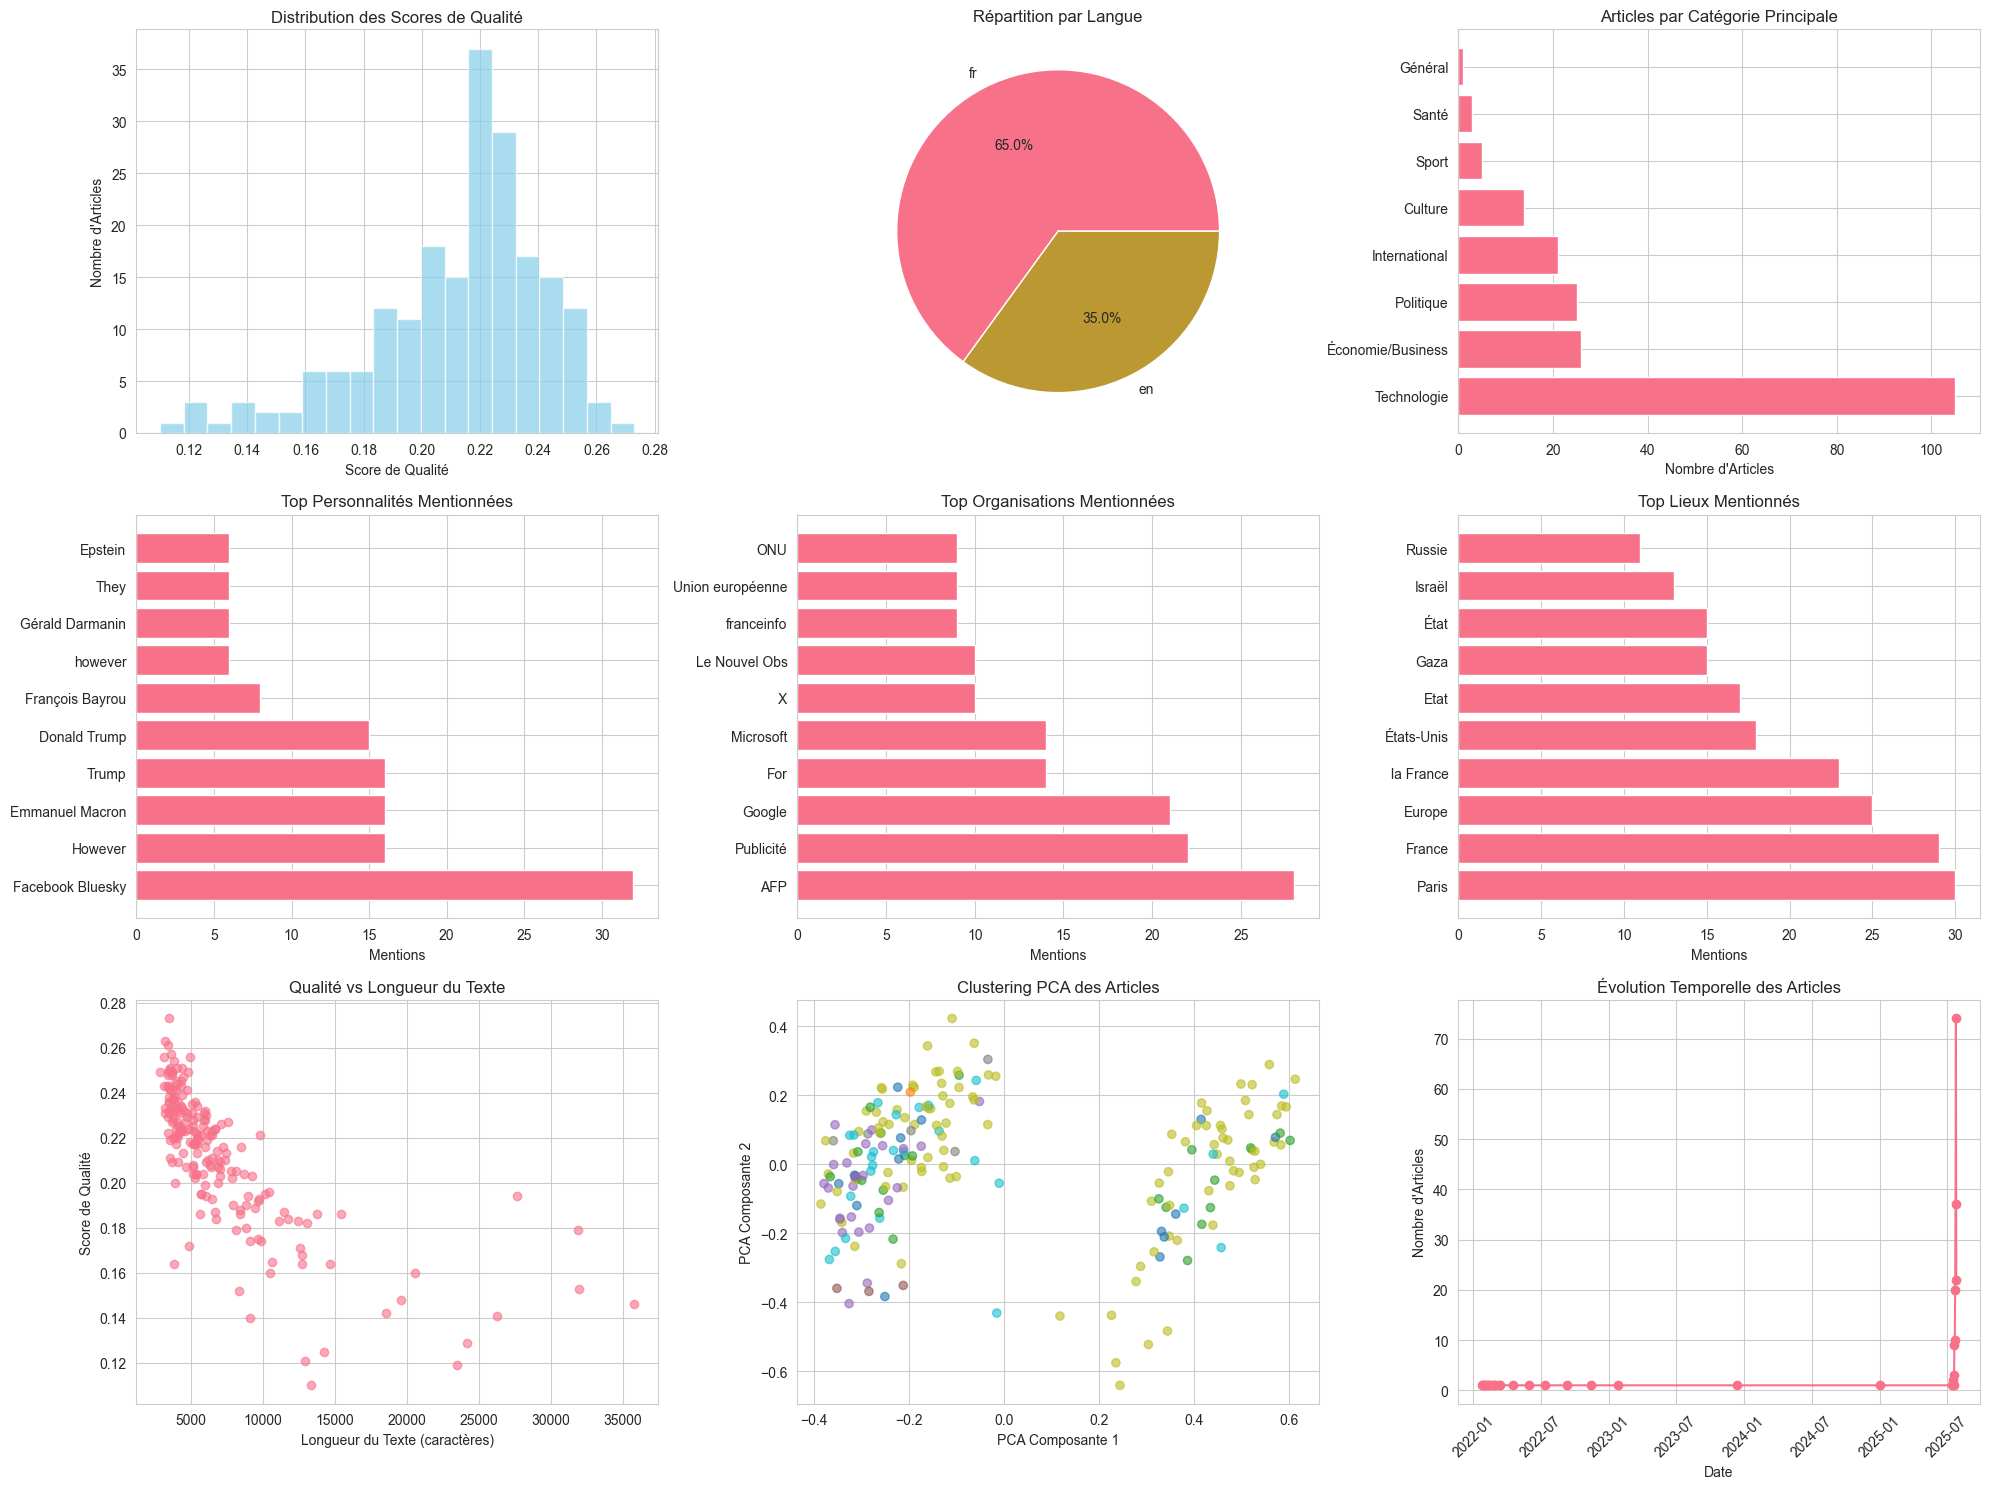

In [20]:

# Configuration des graphiques
fig = plt.figure(figsize=(20, 15))

# 1. Distribution des scores de qualité
if 'quality_score' in df.columns and df['quality_score'].notna().sum() > 0:
    plt.subplot(3, 3, 1)
    df['quality_score'].hist(bins=20, alpha=0.7, color='skyblue')
    plt.title('Distribution des Scores de Qualité')
    plt.xlabel('Score de Qualité')
    plt.ylabel('Nombre d\'Articles')

# 2. Répartition par langue
if 'language' in df.columns and df['language'].notna().sum() > 0:
    plt.subplot(3, 3, 2)
    lang_counts = df['language'].value_counts().head(8)
    plt.pie(lang_counts.values, labels=lang_counts.index, autopct='%1.1f%%')
    plt.title('Répartition par Langue')

# 3. Catégories principales
if 'main_category' in df.columns:
    plt.subplot(3, 3, 3)
    cat_counts = df['main_category'].value_counts()
    plt.barh(range(len(cat_counts)), cat_counts.values)
    plt.yticks(range(len(cat_counts)), cat_counts.index)
    plt.title('Articles par Catégorie Principale')
    plt.xlabel('Nombre d\'Articles')

# 4. Top entités PERSON
if entities_analysis and entities_analysis['PERSON']:
    plt.subplot(3, 3, 4)
    top_persons = dict(Counter(entities_analysis['PERSON']).most_common(10))
    plt.barh(range(len(top_persons)), list(top_persons.values()))
    plt.yticks(range(len(top_persons)), list(top_persons.keys()))
    plt.title('Top Personnalités Mentionnées')
    plt.xlabel('Mentions')

# 5. Top entités ORG
if entities_analysis and entities_analysis['ORG']:
    plt.subplot(3, 3, 5)
    top_orgs = dict(Counter(entities_analysis['ORG']).most_common(10))
    plt.barh(range(len(top_orgs)), list(top_orgs.values()))
    plt.yticks(range(len(top_orgs)), list(top_orgs.keys()))
    plt.title('Top Organisations Mentionnées')
    plt.xlabel('Mentions')

# 6. Top entités LOC
if entities_analysis and entities_analysis['LOC']:
    plt.subplot(3, 3, 6)
    top_locs = dict(Counter(entities_analysis['LOC']).most_common(10))
    plt.barh(range(len(top_locs)), list(top_locs.values()))
    plt.yticks(range(len(top_locs)), list(top_locs.keys()))
    plt.title('Top Lieux Mentionnés')
    plt.xlabel('Mentions')

# 7. Relation qualité vs longueur du texte
if 'quality_score' in df.columns and 'text' in df.columns:
    plt.subplot(3, 3, 7)
    df['text_length'] = df['text'].fillna('').str.len()
    valid_data = df.dropna(subset=['quality_score', 'text_length'])
    if len(valid_data) > 0:
        plt.scatter(valid_data['text_length'], valid_data['quality_score'], alpha=0.6)
        plt.xlabel('Longueur du Texte (caractères)')
        plt.ylabel('Score de Qualité')
        plt.title('Qualité vs Longueur du Texte')

# 8. PCA des embeddings (si disponible)
if embedding_analysis.get('pca_available') and 'df_embeddings' in locals():
    plt.subplot(3, 3, 8)
    scatter = plt.scatter(df_embeddings['pca_x'], df_embeddings['pca_y'], 
                         c=pd.Categorical(df_embeddings['main_category']).codes, 
                         alpha=0.6, cmap='tab10')
    plt.xlabel('PCA Composante 1')
    plt.ylabel('PCA Composante 2')
    plt.title('Clustering PCA des Articles')

# 9. Évolution temporelle (si dates disponibles)
if 'published' in df.columns:
    plt.subplot(3, 3, 9)
    df_with_dates = df.dropna(subset=['published'])
    if len(df_with_dates) > 0:
        df_with_dates['published_date'] = pd.to_datetime(df_with_dates['published'], errors='coerce')
        df_with_dates = df_with_dates.dropna(subset=['published_date'])
        
        if len(df_with_dates) > 0:
            df_with_dates['date_only'] = df_with_dates['published_date'].dt.date
            daily_counts = df_with_dates['date_only'].value_counts().sort_index()
            
            plt.plot(daily_counts.index, daily_counts.values, marker='o')
            plt.title('Évolution Temporelle des Articles')
            plt.xlabel('Date')
            plt.ylabel('Nombre d\'Articles')
            plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [21]:

analysis_results = {
    'metadata': {
        'analysis_date': datetime.now().isoformat(),
        'total_articles': len(df),
        'data_source': data_source,
        'enrichment_quality': {
            'articles_with_quality_score': df['quality_score'].notna().sum() if 'quality_score' in df.columns else 0,
            'articles_with_language': df['language'].notna().sum() if 'language' in df.columns else 0,
            'articles_with_entities': entities_analysis.get('total_articles_with_entities', 0),
            'articles_with_embeddings': df['embedding'].notna().sum() if 'embedding' in df.columns else 0
        }
    },
    'quality_analysis': {},
    'language_analysis': {},
    'entity_analysis': dict(entities_analysis) if entities_analysis else {},
    'categorization': {},
    'similarity_analysis': embedding_analysis
}


In [22]:
# Analyse qualité
if 'quality_score' in df.columns:
    quality_scores = df['quality_score'].dropna()
    if len(quality_scores) > 0:
        analysis_results['quality_analysis'] = {
            'mean': float(quality_scores.mean()),
            'median': float(quality_scores.median()),
            'std': float(quality_scores.std()),
            'min': float(quality_scores.min()),
            'max': float(quality_scores.max()),
            'distribution': {
                'high_quality': int((quality_scores >= 0.8).sum()),
                'medium_quality': int(((quality_scores >= 0.5) & (quality_scores < 0.8)).sum()),
                'low_quality': int((quality_scores < 0.5).sum())
            }
        }

# Analyse langues
if 'language' in df.columns:
    language_counts = df['language'].value_counts()
    analysis_results['language_analysis'] = {
        'total_languages': len(language_counts),
        'distribution': dict(language_counts)
    }

# Analyse catégorisation
if 'main_category' in df.columns:
    category_counts = df['main_category'].value_counts()
    analysis_results['categorization'] = {
        'total_categories': len(category_counts),
        'distribution': dict(category_counts)
    }



In [23]:
# Export JSON des analyses
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
analysis_file = exports_dir / f"analysis_results.json"

try:
    with open(analysis_file, 'w', encoding='utf-8') as f:
        json.dump(analysis_results, f, ensure_ascii=False, indent=2, default=str)
    print(f"Analyses exportées: {analysis_file.name}")
except Exception as e:
    print(f"Erreur export analyses: {e}")

Analyses exportées: analysis_results.json


In [24]:
# Export DataFrame enrichi avec catégories
if 'categories' in df.columns:
    enriched_with_categories_file = exports_dir / f"articles_categorized.json"
    
    try:
        # Sélection des colonnes importantes
        export_columns = ['title', 'summary', 'published', 'source', 'url', 
                         'language', 'quality_score', 'entities', 'categories', 'main_category']
        export_columns = [col for col in export_columns if col in df.columns]
        
        df_export = df[export_columns].copy()
        
        # Conversion en JSON
        with open(enriched_with_categories_file, 'w', encoding='utf-8') as f:
            df_export.to_json(f, orient='records', force_ascii=False, indent=2)
        
        print(f"Articles catégorisés exportés: {enriched_with_categories_file.name}")
    except Exception as e:
        print(f"Erreur export articles catégorisés: {e}")



Articles catégorisés exportés: articles_categorized.json


In [25]:
# Export CSV pour analyse externe
csv_file = exports_dir / f"articles_analysis.csv"

try:
    # Préparation pour CSV (pas d'objets complexes)
    df_csv = df.copy()
    
    # Conversion des listes en strings pour CSV
    if 'categories' in df_csv.columns:
        df_csv['categories_str'] = df_csv['categories'].apply(lambda x: ', '.join(x) if isinstance(x, list) else str(x))
    
    if 'entities' in df_csv.columns:
        df_csv['entities_str'] = df_csv['entities'].apply(lambda x: json.dumps(x) if x else '')
    
    # Colonnes à exporter en CSV
    csv_columns = ['title', 'summary', 'published', 'source', 'url', 
                   'language', 'quality_score', 'main_category', 'categories_str']
    csv_columns = [col for col in csv_columns if col in df_csv.columns]
    
    df_csv[csv_columns].to_csv(csv_file, index=False, encoding='utf-8')
    print(f"CSV d'analyse exporté: {csv_file.name}")
    
except Exception as e:
    print(f"Erreur export CSV: {e}")




CSV d'analyse exporté: articles_analysis.csv


In [26]:

print(f"   Articles analysés: {len(df)}")
print(f"   Source: {data_source}")
print(f"   Enrichissements disponibles:")

if 'quality_score' in df.columns:
    quality_coverage = df['quality_score'].notna().sum() / len(df) * 100
    print(f"      - Scores de qualité: {quality_coverage:.1f}%")

if 'language' in df.columns:
    language_coverage = df['language'].notna().sum() / len(df) * 100
    print(f"      - Détection de langue: {language_coverage:.1f}%")

if entities_analysis:
    entity_coverage = entities_analysis['total_articles_with_entities'] / len(df) * 100
    print(f"      - Entités nommées: {entity_coverage:.1f}%")

if 'embedding' in df.columns:
    embedding_coverage = df['embedding'].notna().sum() / len(df) * 100
    print(f"      - Embeddings: {embedding_coverage:.1f}%")

if 'main_category' in df.columns:
    categorized = (df['main_category'] != 'Non catégorisé').sum()
    categorization_rate = categorized / len(df) * 100
    print(f"      - Catégorisation: {categorization_rate:.1f}%")




   Articles analysés: 200
   Source: JSON
   Enrichissements disponibles:
      - Scores de qualité: 100.0%
      - Détection de langue: 100.0%
      - Entités nommées: 100.0%
      - Embeddings: 100.0%
      - Catégorisation: 100.0%


In [27]:
print(f"\nFICHIERS GÉNÉRÉS:")
print(f"   {analysis_file.name}")
if 'enriched_with_categories_file' in locals():
    print(f"   {enriched_with_categories_file.name}")
print(f"   {csv_file.name}")

print(f"\nTOP INSIGHTS:")
if entities_analysis and entities_analysis['ORG']:
    top_org = Counter(entities_analysis['ORG']).most_common(1)[0]
    print(f"   - Organisation la plus mentionnée: {top_org[0]} ({top_org[1]} mentions)")

if 'main_category' in df.columns:
    top_category = df['main_category'].value_counts().index[0]
    top_category_count = df['main_category'].value_counts().iloc[0]
    print(f"   - Catégorie dominante: {top_category} ({top_category_count} articles)")

if 'language' in df.columns:
    main_language = df['language'].value_counts().index[0]
    main_language_count = df['language'].value_counts().iloc[0]
    print(f"   - Langue principale: {main_language} ({main_language_count} articles)")

if 'quality_score' in df.columns and df['quality_score'].notna().sum() > 0:
    avg_quality = df['quality_score'].mean()
    print(f"   - Score qualité moyen: {avg_quality:.3f}")



FICHIERS GÉNÉRÉS:
   analysis_results.json
   articles_categorized.json
   articles_analysis.csv

TOP INSIGHTS:
   - Organisation la plus mentionnée: AFP (28 mentions)
   - Catégorie dominante: Technologie (105 articles)
   - Langue principale: fr (130 articles)
   - Score qualité moyen: 0.212


In [28]:
print(f"\nPROCHAINES ÉTAPES RECOMMANDÉES:")
print(f"   1. Explorer les catégories détaillées pour insights métier")
print(f"   2. Utiliser les embeddings pour recherche de similarité")
print(f"   3. Analyser les entités pour identifier les tendances")
print(f"   4. Créer des dashboards interactifs basés sur ces analyses")
print(f"   5. Automatiser la catégorisation pour nouveaux articles")



PROCHAINES ÉTAPES RECOMMANDÉES:
   1. Explorer les catégories détaillées pour insights métier
   2. Utiliser les embeddings pour recherche de similarité
   3. Analyser les entités pour identifier les tendances
   4. Créer des dashboards interactifs basés sur ces analyses
   5. Automatiser la catégorisation pour nouveaux articles
